This notebook is by Anastasia Ruzmaikina.

Here we analyse a dataset of nearly 5000 movies. The goal is to be able to predict the revenue of the movie given all the information available about the movie. The available data columns are the title, names of actors and actresses, movie genres, vote count, movie budget etc.

The difficulty here is that using the straightforward linear regession gives a very low R2 value of about 0.34. The question is how to improve the model to increase R2 score. 

We do a complete data analysis, remove outliers, find the independent variables that are most correlated with the revenue, check for multicollinearity, and derive a linear regression model with the highest R2 score possible. We are able to increase the R2 score to 0.689.

First we download all the Python libraries we need to use.

In [52]:
# Data manipulation
import numpy as np 
import pandas as pd

# Data Visualazation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

import random
import scipy.optimize

In [53]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

We download the movie data set from Harvard Edx website.

In [54]:
df = pd.read_csv("https://courses.edx.org/asset-v1:HarvardX+PH526x+2T2019+type@asset+block@movie_data.csv", index_col=0)

df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast
0,237000000,"Action, Adventure, Fantasy, Science Fiction",http://www.avatarmovie.com/,19995,"culture clash, future, space war, space colony...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"Ingenious Film Partners, Twentieth Century Fox...",...,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"Sam Worthington, Zoe Saldana, Sigourney Weaver..."
1,300000000,"Adventure, Fantasy, Action",http://disney.go.com/disneypictures/pirates/,285,"ocean, drug abuse, exotic island, east india t...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",...,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"Johnny Depp, Orlando Bloom, Keira Knightley, S..."
2,245000000,"Action, Adventure, Crime",http://www.sonypictures.com/movies/spectre/,206647,"spy, based on novel, secret agent, sequel, mi6...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"Columbia Pictures, Danjaq, B24",...,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,"Daniel Craig, Christoph Waltz, Léa Seydoux, Ra..."
3,250000000,"Action, Crime, Drama, Thriller",http://www.thedarkknightrises.com/,49026,"dc comics, crime fighter, terrorist, secret id...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",...,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"Christian Bale, Michael Caine, Gary Oldman, An..."
4,260000000,"Action, Adventure, Science Fiction",http://movies.disney.com/john-carter,49529,"based on novel, mars, medallion, space travel,...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,...,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"Taylor Kitsch, Lynn Collins, Samantha Morton, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"Action, Crime, Thriller",NaN,9367,"united states–mexico barrier, legs, arms, pape...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,Columbia Pictures,...,2040920,81.0,Español,Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238,9367,"Carlos Gallardo, Jaime de Hoyos, Peter Marquar..."
4799,9000,"Comedy, Romance",NaN,72766,NaN,en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,NaN,...,0,85.0,NaN,Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5,72766,"Edward Burns, Kerry Bishé, Marsha Dietlein, Ca..."
4800,0,"Comedy, Drama, Romance, TV Movie",http://www.hallmarkchannel.com/signedsealeddel...,231617,"date, love at first sight, narration, investig...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"Front Street Pictures, Muse Entertainment Ente...",...,0,120.0,English,Released,NaN,"Signed, Sealed, Delivered",7.0,6,231617,"Eric Mabius, Kristin Booth, Crystal Lowe, Geof..."
4801,0,NaN,http://shanghaicalling.com/,126186,NaN,en,Shanghai Calling,When ambitious New York attorney Sam is sent t...,0.857008,NaN,...,0,98.0,English,Released,A New Yorker in Shanghai,Shanghai Calling,5.7,7,126186,"Daniel Henney, Eliza Coupe, Bill Paxton, Alan ..."


We create a new column indicating if a movie is profitable. 

The 'profitable' column is the difference between 'revenue' and 'budget' column.

In [55]:
df['profitable'] = df['revenue']
for i in range(len(df['revenue'])):
    if df['revenue'].iloc[i] >= df['budget'].iloc[i]:
        df['profitable'].iloc[i] = 1
    else:
        df['profitable'].iloc[i] = 0

We replace infinite values with NaN values in the data frame. NaN values are handled later.

In [56]:
df = df.replace(to_replace = np.inf, value = np.nan)
df = df.replace(to_replace = -np.inf, value = np.nan)

Next we do a one hot encoding of the 'genres' column. 

First we identify how many different genres are present in the 'genres' column.

We split the genres into different columns. Each column contains 1's or 0's, one if that particlar genre is present in that row.

In [57]:
genr = []
for i in range(len(df['genres'])):
    temp = df['genres'].iloc[i]
    if not (isinstance(temp, float)):
       temp = temp.split(',')
       genr += temp
       
genre = list(set(genr))
for i in range(len(genre)):
    genre[i] = genre[i].strip()
genre = list(set(genre))
for item in genre:
    df[item] = df['budget']
for item in genre:
    for i in range(len(df['genres'])):
        if not (isinstance(df['genres'].iloc[i], float)):
             if item in df['genres'].iloc[i]:
                   df[item].iloc[i] = 1
             else:
                   df[item].iloc[i] = 0

Before solving the problem, it's very important to have a good understanding of data.

First we get the descriptive statistics of the data
Then we get the information about missing values in the data

In [58]:
# Info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4775 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4391 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4452 non-null   object 
 10  production_countries  4629 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4716 non-null   object 
 15  status               

In [59]:
# Summary statistic of the data
df.describe()  

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id,profitable,Thriller,...,Romance,Fantasy,Animation,Music,Crime,Family,Science Fiction,Horror,History,Drama
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000,4803.000000,4803.000000,4.803000e+03,...,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989,57165.484281,0.723923,7.706173e+02,...,7.705382e+02,7.704403e+02,7.704008e+02,7.703906e+02,7.704970e+02,7.704589e+02,7.704635e+02,7.704601e+02,7.703931e+02,7.708303e+02
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891,88694.614033,0.447102,3.441408e+04,...,3.441408e+04,3.441409e+04,3.441409e+04,3.441409e+04,3.441408e+04,3.441408e+04,3.441408e+04,3.441408e+04,3.441409e+04,3.441408e+04
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000,9014.500000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000,14629.000000,1.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000,58610.500000,1.000000,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,459488.000000,1.000000,2.000000e+06,...,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06


In [60]:
# Get count of missing values in every column
print(df.isna().sum())

budget                     0
genres                    28
homepage                3091
id                         0
keywords                 412
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies     351
production_countries     174
release_date               1
revenue                    0
runtime                    2
spoken_languages          87
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
cast                      43
profitable                 0
Thriller                   0
Action                     0
Western                    0
Documentary                0
Foreign                    0
Mystery                    0
War                        0
Adventure                  0
TV Movie                   0
Comedy                     0
Romance                    0
Fantasy       

Conclusions: 

The data contains some categorical columns, these columns need to be handled before building the model

Some columns have missing values, these need to be handled before building the model

The y variable (revenue) doesn't have any missing values, which is good

In [61]:
# Create list of numeric and categorical columns and check if they have extra spaces in the column names
num_col = df.select_dtypes(include=np.number).columns
print("Numerical columns: \n",num_col)

cat_col = df.select_dtypes(exclude=np.number).columns
print("Categorical columns: \n",cat_col)

Numerical columns: 
 Index(['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count', 'movie_id', 'profitable', 'Thriller', 'Action', 'Western',
       'Documentary', 'Foreign', 'Mystery', 'War', 'Adventure', 'TV Movie',
       'Comedy', 'Romance', 'Fantasy', 'Animation', 'Music', 'Crime', 'Family',
       'Science Fiction', 'Horror', 'History', 'Drama'],
      dtype='object')
Categorical columns: 
 Index(['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast'],
      dtype='object')


We already did one hot encoding on the 'genres' column, so we can drop the 'genres' column.

The only categorical column that can influence the 'revenue' column is the 'cast' column. But if we do a one hot encoding, we find that we need a hundred or more columns. Therefore it is impractical to use 'cast' data.

All other categorical columns have very little influence on the revenue from the movie, so we can drop them.

In [62]:
df = df.drop(columns=['genres', 'homepage', 'keywords', 'original_language', 'original_title',
       'overview', 'production_companies', 'production_countries',
       'release_date', 'spoken_languages', 'status', 'tagline', 'title',
       'cast'])

In [63]:
df.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id,profitable,Thriller,...,Romance,Fantasy,Animation,Music,Crime,Family,Science Fiction,Horror,History,Drama
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800,19995,1,0,...,0,1,0,0,0,0,1,0,0,0
1,300000000,285,139.082615,961000000,169.0,6.9,4500,285,1,0,...,0,1,0,0,0,0,0,0,0,0
2,245000000,206647,107.376788,880674609,148.0,6.3,4466,206647,1,0,...,0,0,0,0,1,0,0,0,0,0
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106,49026,1,1,...,0,0,0,0,1,0,0,0,0,1
4,260000000,49529,43.926995,284139100,132.0,6.1,2124,49529,1,0,...,0,0,0,0,0,0,1,0,0,0


Exploratory data analysis is an approach to analyze or investigate data sets to find out patterns and see if any of the variables can be useful in predicting the y variables. Visual methods are often used to summarise the data. Primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing tasks.

We are going to:

Create list of columns by data type

Check the distribution of target variable

Check the correlation between different features

Check the relation between different features


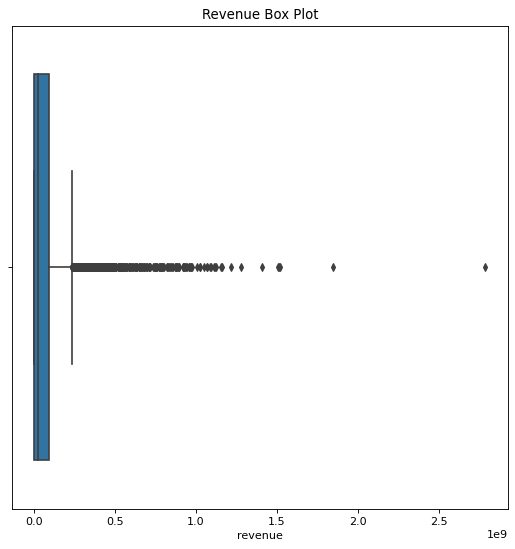

In [64]:
# Check the distribution of y variable (Revenue) using box plot
plt.figure(figsize=(8,8), dpi= 80)
sns.boxplot(df['revenue'])
plt.title('Revenue Box Plot')
plt.show()

<AxesSubplot:title={'center':'Revenue Distribution Plot'}, xlabel='revenue', ylabel='Density'>

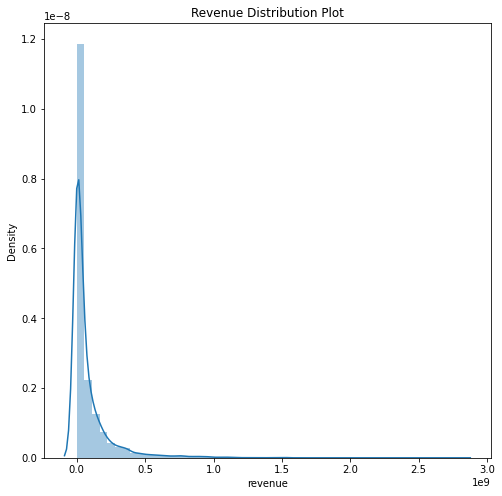

In [65]:
# Check the distribution of y variable (Revenue) using dist plot
plt.figure(figsize=(8,8))
plt.title('Revenue Distribution Plot')
sns.distplot(df['revenue'])

We see that the data set has some very high revenue movies, which contribute to the right skewness of the data. The high kurtosis of the data shows that the data is far from normally distributed.

In [66]:
# Skew and kurt
print("Skewness: %f" % abs(df['revenue']).skew())
print("Kurtosis: %f" % abs(df['revenue']).kurt())

Skewness: 4.444716
Kurtosis: 33.123630


Next we calculate all the correlations between 'revenue' and other columns. We plot the correlations as the heat map.

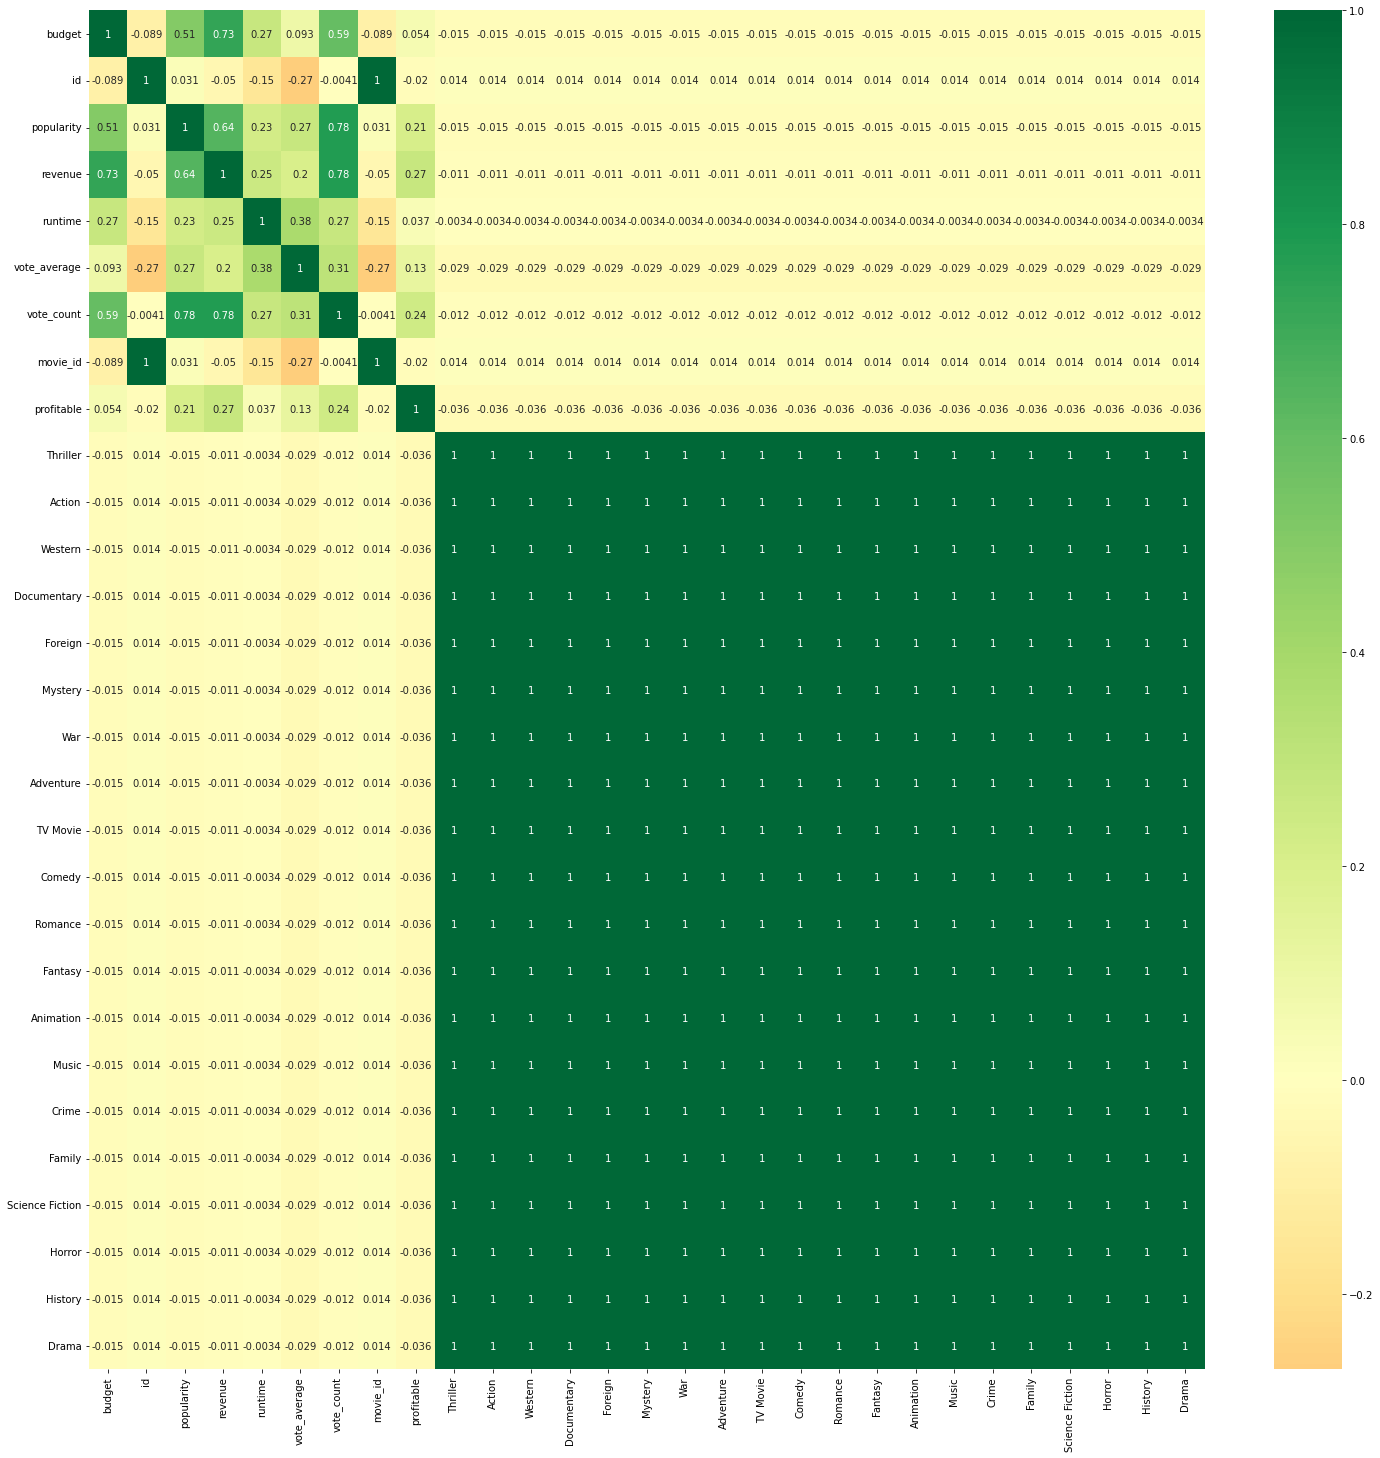

In [67]:
# Check the multicollinearity of features using the correlation matric
plt.figure(figsize=(25,25))
p = sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',center=0) 

Not all of the features have a significant influence on the 'revenue'. 

It is clear that different movie genres have very little influence on the 'revenue'.

Let's look at the correlation matrix of top 7 features, which have the highest correlation with 'revenue'.

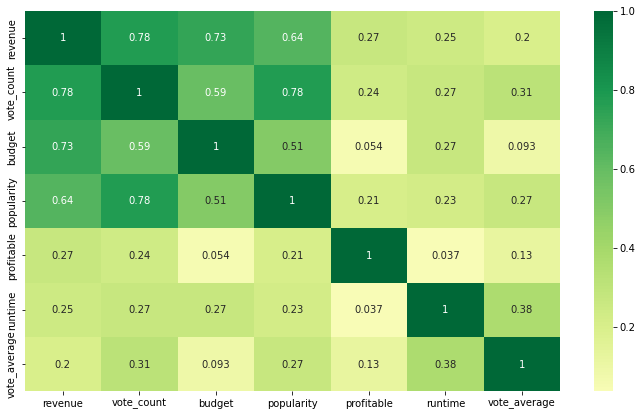

In [68]:
main_columns = ['budget', 'revenue', 'popularity', 'runtime', 'vote_average', 'vote_count', 'profitable']
k = 7 #number of variables for heatmap
cols = df.corr().nlargest(k, 'revenue')['revenue'].index
plt.figure(figsize=(12,7))
p = sns.heatmap(df[cols].corr(), annot=True,cmap='RdYlGn',center=0) 

Now we make scatterplots of different covariates vs the 'revenue'.

In [69]:
def scatterplot(x="vote_count", y='revenue'):
    plt.figure(figsize=(10,7))
    plt.scatter(df[x], df[y], )
    plt.title(x + ' vs ' + y)
    plt.show()

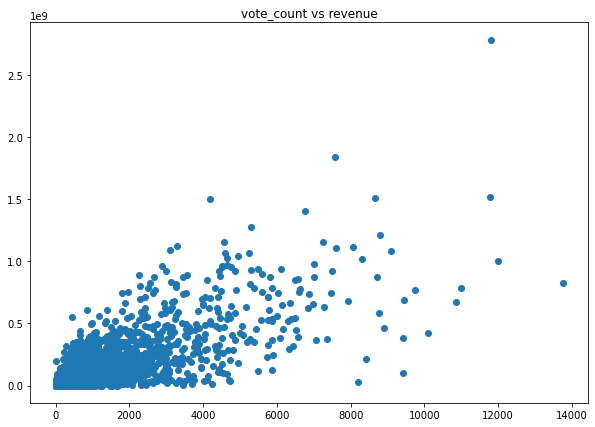

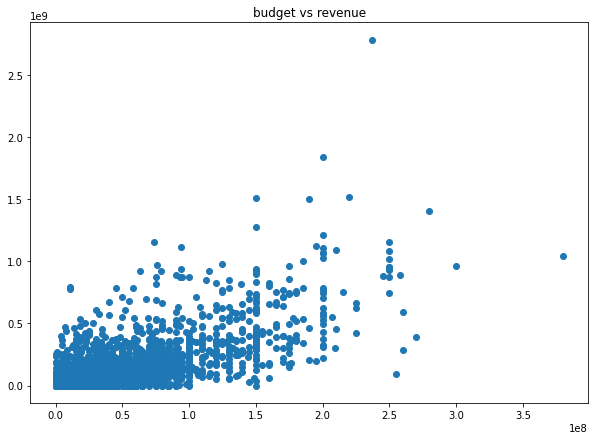

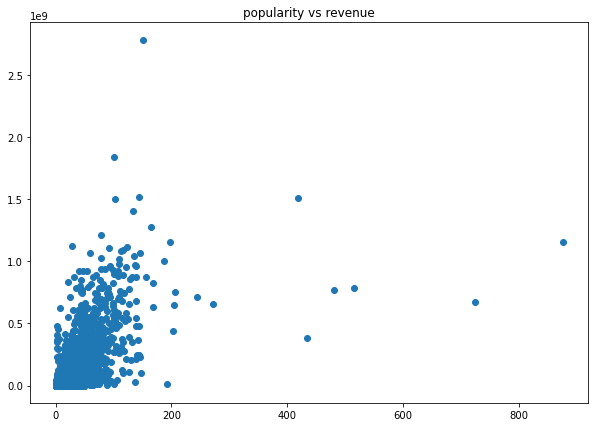

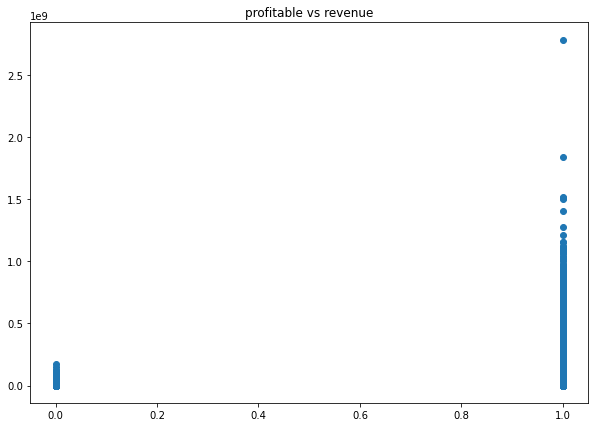

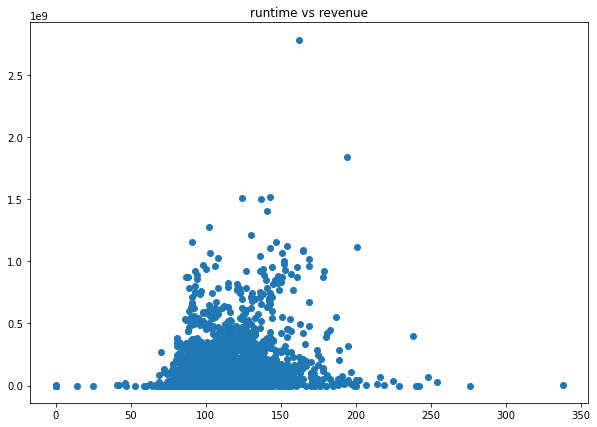

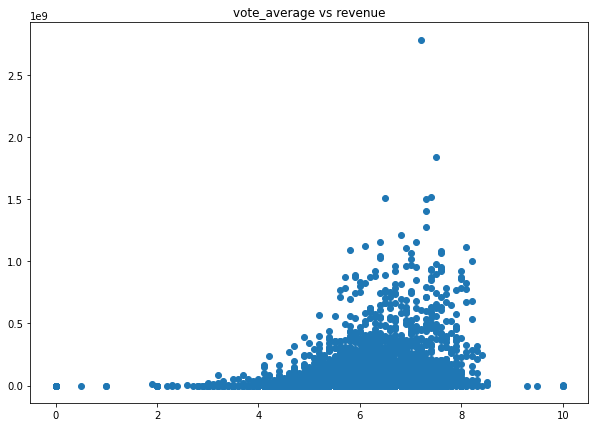

In [70]:
for col in cols[1:]:
    scatterplot(x=col, y='revenue')

We want the highest correlation values between the 'revenue' column and other columns.

In [71]:
corr = df[main_columns].corr()
print (corr['revenue'].sort_values(ascending=False)[-10:])

revenue         1.000000
vote_count      0.781487
budget          0.730823
popularity      0.644724
profitable      0.272273
runtime         0.251093
vote_average    0.197150
Name: revenue, dtype: float64


In [72]:
# Store 7 highest correlated variables for future reference
corr = df.corr()
print (corr['revenue'].sort_values(ascending=False)[1:7])
highest_correlated_cols = corr['revenue'].sort_values(ascending=False)[1:7].index

vote_count      0.781487
budget          0.730823
popularity      0.644724
profitable      0.272273
runtime         0.251093
vote_average    0.197150
Name: revenue, dtype: float64


The data is not yet ready for model building. We need to process the data and make it ready for model building. We are going to:

Clean the data by treating missing values

Detect the outliers and remove those

Split the dataset in X and y dataset

Split the data in train and test set


Missing Value Treatment

Impute the rows with missing values with means of columns

In [73]:
# Get count of missing values in main columns
print(df[main_columns].isna().sum())

budget          0
revenue         0
popularity      0
runtime         2
vote_average    0
vote_count      0
profitable      0
dtype: int64


Since the missing values are only in the 'runtime' column, and there are very few missing values, we are going to fill them with the mean of the column.

In [74]:
df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
print(df[main_columns].isna().sum())

budget          0
revenue         0
popularity      0
runtime         0
vote_average    0
vote_count      0
profitable      0
dtype: int64


Outlier Treatment

Check the Mahalanobis distance of points. If a point has a large Mahalanobis distance, it means that it has a very small Gaussian probability density, so it is unlikely to occur.

Find out the outliers in y variable and remove those.

In [75]:
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = scipy.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

df_x = df[['budget', 'revenue']].head(500)
df_x['mahala'] = mahalanobis(x=df_x, data=df[['budget', 'revenue']])
df_x.head()

,budget,revenue,mahala
0,237000000,2787965087,382.258746
1,300000000,961000000,44.881814
2,245000000,880674609,30.386373
3,250000000,1084939099,39.748064
4,260000000,284139100,50.281533


We can find all the points with Mahalanobis distance larger than four times the mean Mahalanobis distance.

In [76]:
df_xtreme = df_x.loc[df_x.mahala > (4*df_x.mahala.mean())]
print(df_xtreme.shape)
df_xtreme.sort_values('mahala', ascending=False).head(10)

(12, 3)


,budget,revenue,mahala
0,237000000,2787965087,382.258746
25,200000000,1845034188,146.741571
28,150000000,1513528810,102.823504
44,190000000,1506249360,89.208287
16,220000000,1519557910,84.543596
17,380000000,1045713802,74.587861
7,280000000,1405403694,66.117176
124,150000000,1274219009,65.713088
13,255000000,89289910,65.335139
329,94000000,1118888979,60.572693


We can show the points with large Mahalanobis distance in orange.

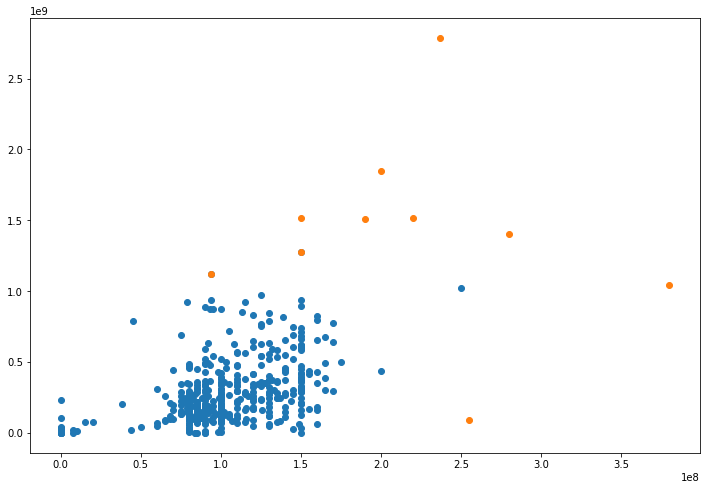

In [77]:
plt.figure(figsize = (12,8))
plt.scatter(df_x['budget'][90:1500], df_x['revenue'][90:1500])
plt.scatter(df_x['budget'].take([0, 25, 28, 44, 16, 17, 7, 124, 13, 329]), df_x['revenue'].take([0, 25, 28, 44, 16, 17, 7, 124, 13, 329]))
plt.show()

In [78]:
df.shape

(4803, 29)

These points are very far from the distribution. 

We are going to drop outliers now, because the mahalanobis distance is calculated with 'budget', which is a significant feature.


In [79]:
df.drop(df_xtreme.index, inplace = True)
df.reset_index(drop=True, inplace=True)
df.shape

(4791, 29)


Outlier Detection using Z-score

Compute Z-scores of the revenue to find outliers.

In [80]:
df['zscore_revenue'] = (df.revenue  - df.revenue.mean() ) / df.revenue.std()
df.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id,profitable,Thriller,...,Fantasy,Animation,Music,Crime,Family,Science Fiction,Horror,History,Drama,zscore_revenue
0,300000000,285,139.082615,961000000,169.0,6.9,4500,285,1,0,...,1,0,0,0,0,0,0,0,0,5.977261
1,245000000,206647,107.376788,880674609,148.0,6.3,4466,206647,1,0,...,0,0,0,1,0,0,0,0,0,5.432771
2,250000000,49026,112.312950,1084939099,165.0,7.6,9106,49026,1,1,...,0,0,0,1,0,0,0,0,1,6.817388
3,258000000,559,115.699814,890871626,139.0,5.9,3576,559,1,0,...,1,0,0,0,0,0,0,0,0,5.501892
4,260000000,38757,48.681969,591794936,100.0,7.4,3330,38757,1,0,...,0,1,0,0,1,0,0,0,0,3.474586


Find revenue outliers by finding the points with z-score greater than 3 or less than -3.

In [81]:
# Get data points that has z score higher than 3 or lower than -3. Another way of saying same thing is get data points that are more than 3 standard deviation away
df[(df.zscore_revenue<-3) | (df.zscore_revenue>3)]

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id,profitable,Thriller,...,Fantasy,Animation,Music,Crime,Family,Science Fiction,Horror,History,Drama,zscore_revenue
0,300000000,285,139.082615,961000000,169.0,6.9,4500,285,1,0,...,1,0,0,0,0,0,0,0,0,5.977261
1,245000000,206647,107.376788,880674609,148.0,6.3,4466,206647,1,0,...,0,0,0,1,0,0,0,0,0,5.432771
2,250000000,49026,112.312950,1084939099,165.0,7.6,9106,49026,1,1,...,0,0,0,1,0,0,0,0,1,6.817388
3,258000000,559,115.699814,890871626,139.0,5.9,3576,559,1,0,...,1,0,0,0,0,0,0,0,0,5.501892
4,260000000,38757,48.681969,591794936,100.0,7.4,3330,38757,1,0,...,0,1,0,0,1,0,0,0,0,3.474586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1478,32350000,1892,46.509071,572700000,135.0,7.9,4665,1892,1,0,...,0,0,0,0,0,1,0,0,0,3.345150
1798,30000000,615,38.171417,611899420,127.0,6.9,864,615,1,0,...,0,0,0,0,0,0,0,0,1,3.610865
1978,18000000,1891,78.517830,538400000,124.0,8.2,5879,1891,1,0,...,0,0,0,0,0,1,0,0,0,3.112646
2900,11000000,11,126.393695,775398007,121.0,8.1,6624,11,1,0,...,0,0,0,0,0,1,0,0,0,4.719149


The points with Z-score of the revenue less than -3 or greater than 3 are outliers and should be dropped.

In [82]:
# Drop Outliers
df.drop(df[(df.zscore_revenue<-3) | (df.zscore_revenue>3)].index, inplace = True)
df.reset_index(drop=True, inplace=True)

In [83]:
df.shape

(4663, 30)

Split the dataset in X and y dataset

Split the data in train and test set

In [84]:
# Split the dataset in X and y
X = df.drop(columns=['revenue'])
y = df[['revenue']]

In [85]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

X_train.head()

,budget,id,popularity,runtime,vote_average,vote_count,movie_id,profitable,Thriller,Action,...,Fantasy,Animation,Music,Crime,Family,Science Fiction,Horror,History,Drama,zscore_revenue
1813,0,25353,1.684948,82.0,3.8,7,25353,1,0,0,...,0,1,0,0,1,0,0,0,0,-0.536925
1410,30000000,1669,46.212155,134.0,7.2,957,1669,1,1,1,...,0,0,0,0,0,0,0,0,0,0.813362
1913,0,7548,7.588597,114.0,5.9,128,7548,1,0,0,...,0,0,0,0,0,0,0,0,1,-0.536925
3615,7000000,13408,2.453459,93.0,5.3,26,13408,1,0,1,...,0,0,0,0,0,0,0,0,0,-0.467585
1889,22000000,10950,26.071644,132.0,7.2,530,10950,1,0,0,...,0,0,0,0,0,0,0,0,1,0.090378


Building Linear Regression

In [86]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf  # formula api

In [87]:
Lmod = LinearRegression()
Lmod.fit(X=df.loc[:, ['budget']], y=df['revenue'])
print("Coefs: ", Lmod.coef_)
print("Intercept: ", Lmod.intercept_)

Coefs:  [1.93693911]
Intercept:  11647173.13590566


The first Linear Regression model is using 'budget' as an independent variable to predict 'revenue'.

In [88]:
mod = smf.ols(formula='revenue ~ budget', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     4066.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:46:42   Log-Likelihood:                -90837.
No. Observations:                4663   AIC:                         1.817e+05
Df Residuals:                    4661   BIC:                         1.817e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.165e+07   1.28e+06      9.086      0.0

Now we are going to try a Linear Regression model with 'budget', 'vote_count' and 'vote_average' as covariates.

In [89]:
# Add a constant
X_data = sm.add_constant(df[['budget', 'vote_count', 'vote_average']])
Y_data = df['revenue']
X_data.head()

,const,budget,vote_count,vote_average
0,1.0,270000000,1400,5.4
1,1.0,225000000,1630,6.3
2,1.0,200000000,1398,6.2
3,1.0,180000000,1303,5.8
4,1.0,209000000,2114,5.5


In [90]:
# Create a first ols model
mod_s = sm.OLS(Y_data, X_data).fit()
print(mod_s.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     2680.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:46:57   Log-Likelihood:                -89961.
No. Observations:                4663   AIC:                         1.799e+05
Df Residuals:                    4659   BIC:                         1.800e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.777e+06   4.56e+06     -1.924   

Extract Parameters

In [91]:
mod_s.params

const          -8.777125e+06
budget          1.330301e+00
vote_count      4.756329e+04
vote_average    1.493160e+06
dtype: float64

In [92]:
mod_s.fittedvalues

0       4.250558e+08
1       3.774756e+08
2       3.330341e+08
3       3.013123e+08
4       3.780169e+08
            ...     
4658    1.269046e+07
4659    2.823099e+05
4660    1.960377e+06
4661    6.683169e+04
4662    1.390797e+06
Length: 4663, dtype: float64

In [93]:
mod_s.rsquared

0.6331566709916323

In [94]:
mod_s.rsquared_adj

0.6329204550682528

Cooks Distance for Influential Data Points

Cook’s Distance does one thing: it measures how much all of the fitted values in the model change when the i-th data point is deleted.

If i-th data point is influential, it is most likely an outlier and should be dropped from the data set.

In [95]:
# Cooks Distance
np.set_printoptions(suppress=True)

# create instance of influence
influence = mod_s.get_influence()

# obtain Cook's distance for each observation
cooks = influence.cooks_distance

# display Cook's distances
print(cooks)

(array([0.00116921, 0.00114991, 0.00025148, ..., 0.00000016, 0.        ,
       0.00000005]), array([0.99999727, 0.99999736, 0.99999987, ..., 1.        , 1.        ,
       1.        ]))


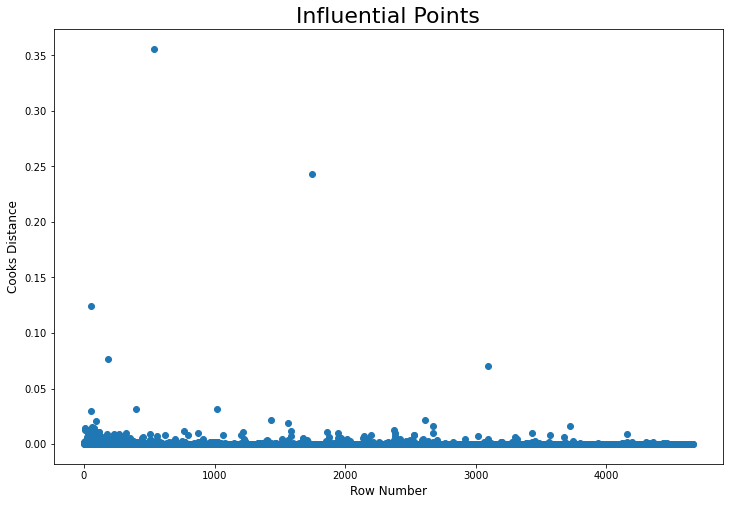

In [96]:
# Draw plot
plt.figure(figsize = (12, 8))
plt.scatter(X_data.index, cooks[0])
plt.xlabel('Row Number', fontsize = 12)
plt.ylabel('Cooks Distance', fontsize = 12)
plt.title('Influential Points', fontsize = 22)
plt.show()

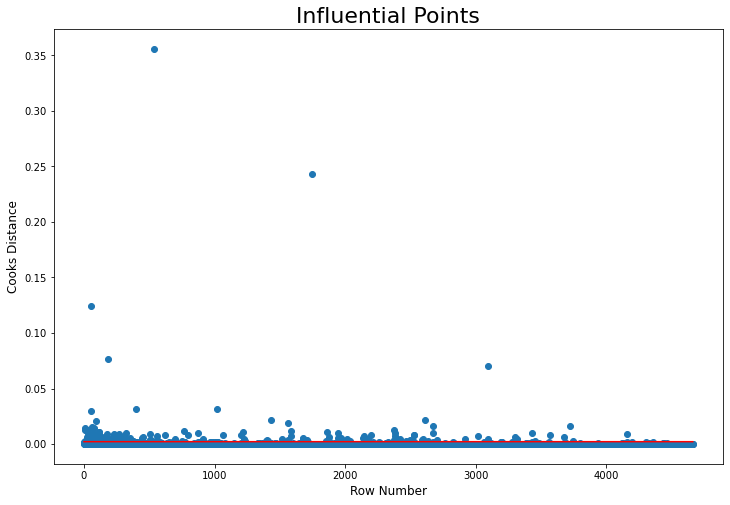

In [97]:
# Influentials are those that are at least 4 times the mean CD.
mean_cooks = np.nanmean(cooks[0])
mean_cooks_list =[4*mean_cooks for i in X_data.index]

# Draw plot
plt.figure(figsize = (12, 8))
plt.scatter(X_data.index, cooks[0])
plt.plot(X_data.index, mean_cooks_list, color="red")
plt.xlabel('Row Number', fontsize = 12)
plt.ylabel('Cooks Distance', fontsize = 12)
plt.title('Influential Points', fontsize = 22)
plt.show()

In [98]:
# Influential points
influential_points = X_data.index[cooks[0] > 4*mean_cooks]
influential_points

df.iloc[influential_points, :]

,budget,id,popularity,revenue,runtime,vote_average,vote_count,movie_id,profitable,Thriller,...,Fantasy,Animation,Music,Crime,Family,Science Fiction,Horror,History,Drama,zscore_revenue
4,209000000,44833,64.928382,303025485,131.0,5.5,2114,44833,1,1,...,0,0,0,0,0,1,0,0,0,1.517148
8,200000000,44912,51.872839,219851172,114.0,5.1,2487,44912,1,1,...,0,0,0,0,0,1,0,0,0,0.953347
11,195000000,81005,43.349855,197687603,114.0,5.5,2598,81005,1,0,...,1,0,0,0,1,0,0,0,0,0.803110
20,176000003,76757,85.369080,183987723,124.0,5.2,2768,76757,1,0,...,1,0,0,0,0,1,0,0,0,0.710245
22,175000000,15512,36.167578,381509870,94.0,6.0,1423,15512,1,0,...,0,1,0,0,1,1,0,0,0,2.049158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3673,4000000,770,48.982550,400176459,238.0,7.7,970,770,1,0,...,0,0,0,0,0,0,0,0,1,2.175691
3725,3300000,244786,192.528841,13092000,105.0,8.3,4254,244786,1,0,...,0,0,0,0,0,0,0,0,1,-0.448180
3747,4000000,627,63.513324,16491080,93.0,7.8,2655,627,1,0,...,0,0,0,1,0,0,0,0,1,-0.425139
4160,1200000,500,66.925866,14661007,99.0,8.0,3697,500,1,1,...,0,0,0,1,0,0,0,0,0,-0.437545


Remove extreme influential points and rebuild

In [99]:
# Remove Influencial points: Likely to be outiers, harder to predict accurately.
influential_points = X_data.index[cooks[0] > 4*mean_cooks]
infuential_mask = df['id'].isin(df.iloc[influential_points, :]['id'].values)
print("Removing these many top influential observations: ", infuential_mask.sum())
df_ = df.loc[infuential_mask, :]

Removing these many top influential observations:  184


Build the model again.

X are the columns 'budget', 'vote_count', 'vote_average', y is the 'revenue' column.

In [107]:
# Split the dataset in X and y
X_ = df.drop(columns=['revenue'])
y = df[['revenue']]

X = sm.add_constant(X_[['budget', 'vote_count', 'vote_average']])
y = df['revenue']

In [108]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
X_train.head()

,const,budget,vote_count,vote_average
1813,1.0,0,7,3.8
1410,1.0,30000000,957,7.2
1913,1.0,0,128,5.9
3615,1.0,7000000,26,5.3
1889,1.0,22000000,530,7.2


In [109]:
# Create ols model on train data
mod_t = sm.OLS(y_train, X_train).fit()
print(mod_t.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     2058.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        12:55:44   Log-Likelihood:                -62873.
No. Observations:                3264   AIC:                         1.258e+05
Df Residuals:                    3260   BIC:                         1.258e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.276e+07   5.32e+06     -2.400   

Evaluation Metrics

In [110]:
# predict on test data
y_pred = mod_t.predict(X_test)
y_pred_train = mod_t.predict(X_train)

In [111]:
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [112]:
# Eval metrics: Test, Train
print("MSE     : ", mean_squared_error(y_test,  y_pred).round(2), ", ", mean_squared_error(y_train,  y_pred_train).round(2))
print("MAPE    : ", mean_absolute_percentage_error(y_test,  y_pred).round(2), ", ", mean_absolute_percentage_error(y_train,  y_pred_train).round(2))
print("R2      : ", r2_score(y_test,  y_pred).round(3), ", ", r2_score(y_train,  y_pred_train).round(3))
print("MAE     : ", mean_absolute_error(y_test,  y_pred).round(2), ", ", mean_absolute_error(y_train,  y_pred_train).round(2))
print("ExpVar  : ", explained_variance_score(y_test,  y_pred).round(3), ", ", explained_variance_score(y_train,  y_pred_train).round(3))  # same as R-sq


MSE     :  3806247468248877.0 ,  3153826173364732.0
MAPE    :  1.6227292764379426e+22 ,  1.8087258182891652e+22
R2      :  0.583 ,  0.654
MAE     :  35491072.76 ,  33242744.35
ExpVar  :  0.583 ,  0.654


Checking Model Assumptions

Try the same model but without train, test split

In [125]:
mod = smf.ols(formula='revenue ~ budget + vote_average + vote_count', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     2680.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:13:52   Log-Likelihood:                -89961.
No. Observations:                4663   AIC:                         1.799e+05
Df Residuals:                    4659   BIC:                         1.800e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -8.777e+06   4.56e+06     -1.924   

Condition Number: Meant to be a measure to detect multicollinearity. Ratio of largest to smallest eigenvalue of exog vars. Gives warning if it exceeds value of 30, which is too low. Known to be sensitive to scaling. Better use VIF based method instead. 

In [126]:
# Mean of the residuals
res.resid.mean()

-7.899325087733619e-08

Check VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating VIF for i-th column is:

𝑉𝐼𝐹_𝑖=1/(1−(𝑅_𝑖)^2)

In [127]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

design_mat = df[['budget', 'vote_count', 'vote_average']]

vif = pd.DataFrame()
vif['Features'] = design_mat.columns
vif['VIF'] = [variance_inflation_factor(design_mat.values, i) for i in range(design_mat.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,budget,1.95
1,vote_count,1.84
2,vote_average,1.71


Rebuild the model

Use 'budget', 'vote_average' and 'popularity' columns to predict 'revenue'.

In [128]:
# Remove vote_count add popularity
mod = smf.ols(formula='revenue ~ budget + vote_average + popularity', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     2354.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:14:56   Log-Likelihood:                -90148.
No. Observations:                4663   AIC:                         1.803e+05
Df Residuals:                    4659   BIC:                         1.803e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -2.289e+07   4.69e+06     -4.877   

In [129]:
# VIF
design_mat = df[['budget', 'vote_average', 'popularity']]

vif = pd.DataFrame()
vif['Features'] = design_mat.columns
vif['VIF'] = [variance_inflation_factor(design_mat.values, i) for i in range(design_mat.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,popularity,2.55
1,vote_average,2.06
0,budget,2.03


Check for Heteroscedasticity

Heteroscedasticity is a situation where the variance of the residuals is unequal over a range of measured values

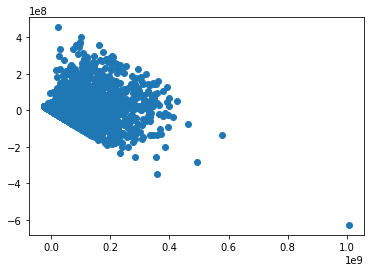

In [130]:
# Fitted vs Residuals
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(res.fittedvalues, res.resid);

Here the model has some heteroscedasticity.

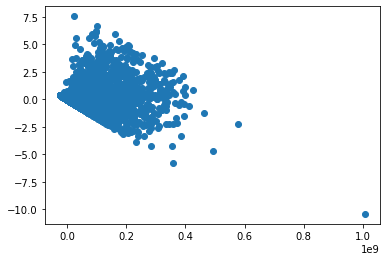

In [131]:
# Standardized residuals
fig, ax = plt.subplots(figsize=(6,4))
resid_standardized = (res.resid-res.resid.mean())/res.resid.std()
ax.scatter(res.fittedvalues, resid_standardized);

Overcoming Heteroscedasticity

Do some transformations on the variables: Log and Box Cox

Rebuild the model with new variables.

In [132]:
mod = smf.ols(formula='np.log(revenue+1) ~ np.log(budget+1) + np.log(vote_count+1) + vote_average', data=df)
res = mod.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     np.log(revenue + 1)   R-squared:                       0.592
Model:                             OLS   Adj. R-squared:                  0.592
Method:                  Least Squares   F-statistic:                     2254.
Date:                 Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                         13:23:21   Log-Likelihood:                -14309.
No. Observations:                 4663   AIC:                         2.863e+04
Df Residuals:                     4659   BIC:                         2.865e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

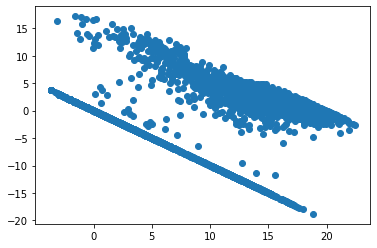

In [133]:
# Fitted vs Residuals
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(res.fittedvalues, res.resid);

It is clear that taking logarithms does not combat Heteroscedasticity.

Try Box-Cox transformation instead.

BoxCox Transformation

It is used to transform a non-normal variable to take close to a normal shape.

y = (x**lambda - 1) / lambda,  for lambda != 0
    log(x),                    for lambda = 0

In [134]:
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df['revenue']+0.001)
df['revenue_boxcox'] = fitted_data
print("Lambda", fitted_lambda)

Lambda 0.0831349938544955


In [135]:
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df['budget']+0.001)
df['budget_boxcox'] = fitted_data
print("Lambda", fitted_lambda)

Lambda 0.13572758801570067


In [136]:
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df['vote_count']+0.001)
df['vote_count_boxcox'] = fitted_data
print("Lambda", fitted_lambda)

Lambda 0.181138671546832


In [137]:
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df['vote_average']+0.001)
df['vote_average_boxcox'] = fitted_data
print("Lambda", fitted_lambda)

Lambda 1.6403808933643558


In [138]:
# Fit model
mod = smf.ols(formula='revenue_boxcox ~ budget_boxcox + vote_average_boxcox + vote_count_boxcox', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         revenue_boxcox   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     2585.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:24:00   Log-Likelihood:                -18625.
No. Observations:                4663   AIC:                         3.726e+04
Df Residuals:                    4659   BIC:                         3.728e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -7.6109    

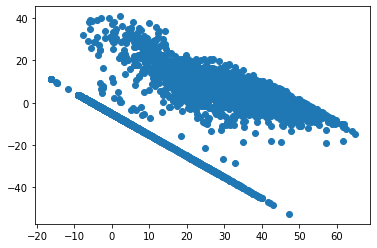

In [139]:
# Fitted vs Residuals
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(res.fittedvalues, res.resid);

Once again, from the residual plot it is clear that Box-Cox transformation does not overcome Heteroscedasticity.

Conclusion, we are not going to apply any transformations to the columns of df.

It is clear that rows with budget = 0 or revenue = 0 do not make sense, so we are going to drop them before proceeding with our linear regression model.

In [140]:
df.drop(df[(df['budget'] == 0) & (df['revenue'] == 0)].index, inplace=True)

Model Building Approach 1 : Forward Selection (Manual)

It is a modelling/feature selection approach where we start with a model that doesn't contain any feature and then we start adding the most significant features one after the other. It is also known as forward selection.

p-value and r2 value are the criterion for checking if the added variable added any value to the model or not

We proceed in the following sequence:

Build model with 1 variable

Build model with 2 variables

Build model with 3 variables

In [141]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.3, random_state=1234)
X_train.head()

,budget,id,popularity,runtime,vote_average,vote_count,movie_id,profitable,Thriller,Action,...,Fantasy,Animation,Music,Crime,Family,Science Fiction,Horror,History,Drama,zscore_revenue
1813,0,25353,1.684948,82.0,3.8,7,25353,1,0,0,...,0,1,0,0,1,0,0,0,0,-0.536925
1410,30000000,1669,46.212155,134.0,7.2,957,1669,1,1,1,...,0,0,0,0,0,0,0,0,0,0.813362
1913,0,7548,7.588597,114.0,5.9,128,7548,1,0,0,...,0,0,0,0,0,0,0,0,1,-0.536925
3615,7000000,13408,2.453459,93.0,5.3,26,13408,1,0,1,...,0,0,0,0,0,0,0,0,0,-0.467585
1889,22000000,10950,26.071644,132.0,7.2,530,10950,1,0,0,...,0,0,0,0,0,0,0,0,1,0.090378


Build model with 1 variable

In [142]:
# Select only one feature in regression model
X_train1 = X_train['budget']

In [143]:
# Add a constant
X_train1 = sm.add_constant(X_train1)

# Create a first ols model
model_1 = sm.OLS(y_train, X_train1).fit()

In [144]:
# Check parameters created
model_1.params

const     1.029400e+07
budget    1.984093e+00
dtype: float64

In [145]:
# Summary of the model
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     3082.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:25:20   Log-Likelihood:                -63522.
No. Observations:                3264   AIC:                         1.270e+05
Df Residuals:                    3262   BIC:                         1.271e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.029e+07    1.5e+06      6.844      0.0

It is clear that one parameter model has a low R2 score.

Build model with 2 variables

In [150]:
# Add one more feature in regression model
X_train2 = X_train[['budget','vote_average']]

In [151]:
# Add a constant
X_train2 = sm.add_constant(X_train2)

# Create second ols model
model_2 = sm.OLS(y_train, X_train2).fit()

In [152]:
# Check parameters created
model_2.params

const          -6.574540e+07
budget          1.960823e+00
vote_average    1.264347e+07
dtype: float64

In [153]:
# Summary of the model
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     1702.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:26:44   Log-Likelihood:                -63441.
No. Observations:                3264   AIC:                         1.269e+05
Df Residuals:                    3261   BIC:                         1.269e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.575e+07   6.09e+06    -10.794   

In [154]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train2.columns
vif['VIF'] = [variance_inflation_factor(X_train2.values, i) for i in range(X_train2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,27.09
1,budget,1.00
2,vote_average,1.00


There is no multicollinearity, because VIF values are low, but the R2 score of 0.511 is lower than for some 3 parameter models we have seen.

Build a model with 3 variables

In [155]:
# Adding one more feature in regression model
X_train3 = X_train[['budget', 'vote_count', 'vote_average']]

In [156]:
# Add a constant
X_train3 = sm.add_constant(X_train3)

# Create third fitted model
model_3 = sm.OLS(y_train, X_train3).fit()

In [157]:
# Check parameters created
model_3.params

const          -1.276472e+07
budget          1.365551e+00
vote_count      4.708736e+04
vote_average    1.992905e+06
dtype: float64

In [158]:
# Summary of the model
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     2058.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:28:13   Log-Likelihood:                -62873.
No. Observations:                3264   AIC:                         1.258e+05
Df Residuals:                    3260   BIC:                         1.258e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.276e+07   5.32e+06     -2.400   

In [159]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train3.columns
vif['VIF'] = [variance_inflation_factor(X_train3.values, i) for i in range(X_train3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,29.23
2,vote_count,1.45
1,budget,1.31
3,vote_average,1.13


We have achieved an Adj R-squared of 0.654 by manually picking the highly correlated variables.

We can keep on adding variables one by one till the model stops improving.

Now lets look at another approach of building a regression model.


Model Building Approach 2 : Manual Backward Selection


Backward stepwise selection is a variable selection method.

Steps associated in backward stepwise selection are :

Create a model with all variables under consideration (we can choose top 10, 15, 20 etc as well).  In this case we will consider 7 variables

Remove the least significant variables one after the other

Keep on removing the variables until all the variables in model are significant and follow the assumptions of linear regression

First, we choose 7 best variables using correlation

Then we eliminate variables one by one using p-value and VIF

In [164]:
# Creating X_train dataframe with highest correlation variables
# Add a constant
X_data = sm.add_constant(df[['budget', 'vote_count', 'vote_average', 'popularity', 'runtime', 'profitable']])
Y_data = df['revenue']
X_data.head()

,const,budget,vote_count,vote_average,popularity,runtime,profitable
0,1.0,270000000,1400,5.4,57.925623,154.0,1
1,1.0,225000000,1630,6.3,53.978602,150.0,1
2,1.0,200000000,1398,6.2,37.668301,140.0,1
3,1.0,180000000,1303,5.8,42.990906,113.0,1
4,1.0,209000000,2114,5.5,64.928382,131.0,1


In [165]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=1234)
X_train.head()

,const,budget,vote_count,vote_average,popularity,runtime,profitable
669,1.0,58000000,1658,6.1,1.551497,119.0,0
2267,1.0,17000000,687,5.6,27.654472,100.0,1
1222,1.0,36000000,379,6.5,19.167377,105.0,1
2627,1.0,13000000,135,5.5,11.880899,106.0,1
1497,1.0,30000000,458,4.8,15.895340,87.0,1


In [166]:
random.seed(0)

# Add a constant
X_train_corrc = sm.add_constant(X_train)

# Build the model with RFE features
lm_corr = sm.OLS(y_train,X_train).fit()

#Summary of linear model
print(lm_corr.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     973.0
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:34:02   Log-Likelihood:                -50886.
No. Observations:                2641   AIC:                         1.018e+05
Df Residuals:                    2634   BIC:                         1.018e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.701e+07    8.4e+06     -3.216   

In [167]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,58.34
2,vote_count,3.52
4,popularity,3.49
3,vote_average,1.42
1,budget,1.41
5,runtime,1.23
6,profitable,1.20


After passing the arbitary selected columns we will manually evaluate each models p-value and VIF value. Unless we find the acceptable range for p-values and VIF we keep dropping the variables one at a time based on below criteria.

High p-value High VIF : Drop the variable

High p-value Low VIF : Drop the variable with high p-value first

Low p-value Low VIF : accept the variable

Check VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating VIF is:

𝑉𝐼𝐹_𝑖=1/(1−(𝑅_𝑖)^2)

The 'popularity' column has the highest p-value, so we are going to drop it from the model.

In [171]:
# Dropping insignificant variables

X_train_corr1 = X_train.drop(['popularity'], 1,)

# Adding a constant variable and Build a second fitted model

X_train_corr1 = sm.add_constant(X_train_corr1)
lm_corr1 = sm.OLS(y_train, X_train_corr1).fit()

#Summary of linear model
print(lm_corr1.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     1168.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:47:15   Log-Likelihood:                -50886.
No. Observations:                2641   AIC:                         1.018e+05
Df Residuals:                    2635   BIC:                         1.018e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.702e+07    8.4e+06     -3.218   

In [172]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_corr1.columns
vif['VIF'] = [variance_inflation_factor(X_train_corr1.values, i) for i in range(X_train_corr1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,58.34
2,vote_count,1.55
3,vote_average,1.41
1,budget,1.38
4,runtime,1.23
5,profitable,1.17


We are going to drop 'runtime' because it has a high p-value

In [173]:
# Dropping insignificant variables

X_train_corr2 = X_train_corr1.drop('runtime', 1,)

# Adding a constant variable and Build a second fitted model

X_train_corr2 = sm.add_constant(X_train_corr2)
lm_corr2 = sm.OLS(y_train, X_train_corr2).fit()

#Summary of linear model
print(lm_corr2.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     1459.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:48:04   Log-Likelihood:                -50887.
No. Observations:                2641   AIC:                         1.018e+05
Df Residuals:                    2636   BIC:                         1.018e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.275e+07    7.8e+06     -2.918   

In [174]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_corr2.columns
vif['VIF'] = [variance_inflation_factor(X_train_corr2.values, i) for i in range(X_train_corr2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,50.26
2,vote_count,1.55
1,budget,1.31
3,vote_average,1.22
4,profitable,1.17


Next we are going to drop the 'vote_average' column because it has a high p-value.

In [175]:
# Dropping insignificant variables

X_train_corr3 = X_train_corr2.drop('vote_average', 1,)

# Adding a constant variable and Build a second fitted model

X_train_corr3 = sm.add_constant(X_train_corr3)
lm_corr3 = sm.OLS(y_train, X_train_corr3).fit()

#Summary of linear model
print(lm_corr3.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     1944.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:51:32   Log-Likelihood:                -50888.
No. Observations:                2641   AIC:                         1.018e+05
Df Residuals:                    2637   BIC:                         1.018e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.263e+07   2.03e+06    -16.076      0.0

In [179]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train_corr3.columns
vif['VIF'] = [variance_inflation_factor(X_train_corr3.values, i) for i in range(X_train_corr3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,3.41
2,vote_count,1.38
1,budget,1.23
3,profitable,1.14


Conclusion: the best linear regression model containes three predictor variables: vote_count, budget and profitable. 

The R2 Score is 0.689. 

The information whether the movie is profitable is available much earlier than the information about revenue.

However, if we don't want to include 'profitable', we can drop it from the model.

In [180]:
X_train_corr4 = X_train_corr3.drop('profitable', 1,)

# Adding a constant variable and Build a third fitted model

X_train_corr4 = sm.add_constant(X_train_corr4)
lm_corr4 = sm.OLS(y_train, X_train_corr4).fit()

#Summary of linear model
print(lm_corr4.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     2138.
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:55:26   Log-Likelihood:                -51156.
No. Observations:                2641   AIC:                         1.023e+05
Df Residuals:                    2638   BIC:                         1.023e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.484e+05    1.7e+06     -0.205      0.8

It is clear that the two predictor Linear Regression model is not as good as a three predictor model.

The best Linear Regression model is the model with three predictors includes the independent variables: vote_count, budget and profitable and has the R2 Score of 0.689.

If we don't want to use 'profitable' as a predictor, the next best model with three predictors includes the independent variables: 'budget', 'vote_count', 'vote_average' and has the R2 Score of 0.654.